# Using LLM for anomalies detections

## EDA

In [ ]:
df.columns

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("/kaggle/input/transactions/card_transaction.v1.csv")

In [3]:
num_cols = [c for c in df.columns[:-1] if len(df[c].unique()) > 2]
bin_cols = [c for c in df.columns[:-1] if len(df[c].unique()) == 2]
print(f'Numeric: {num_cols}')
print(f'Binary: {bin_cols}')

Numeric: ['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?']
Binary: []


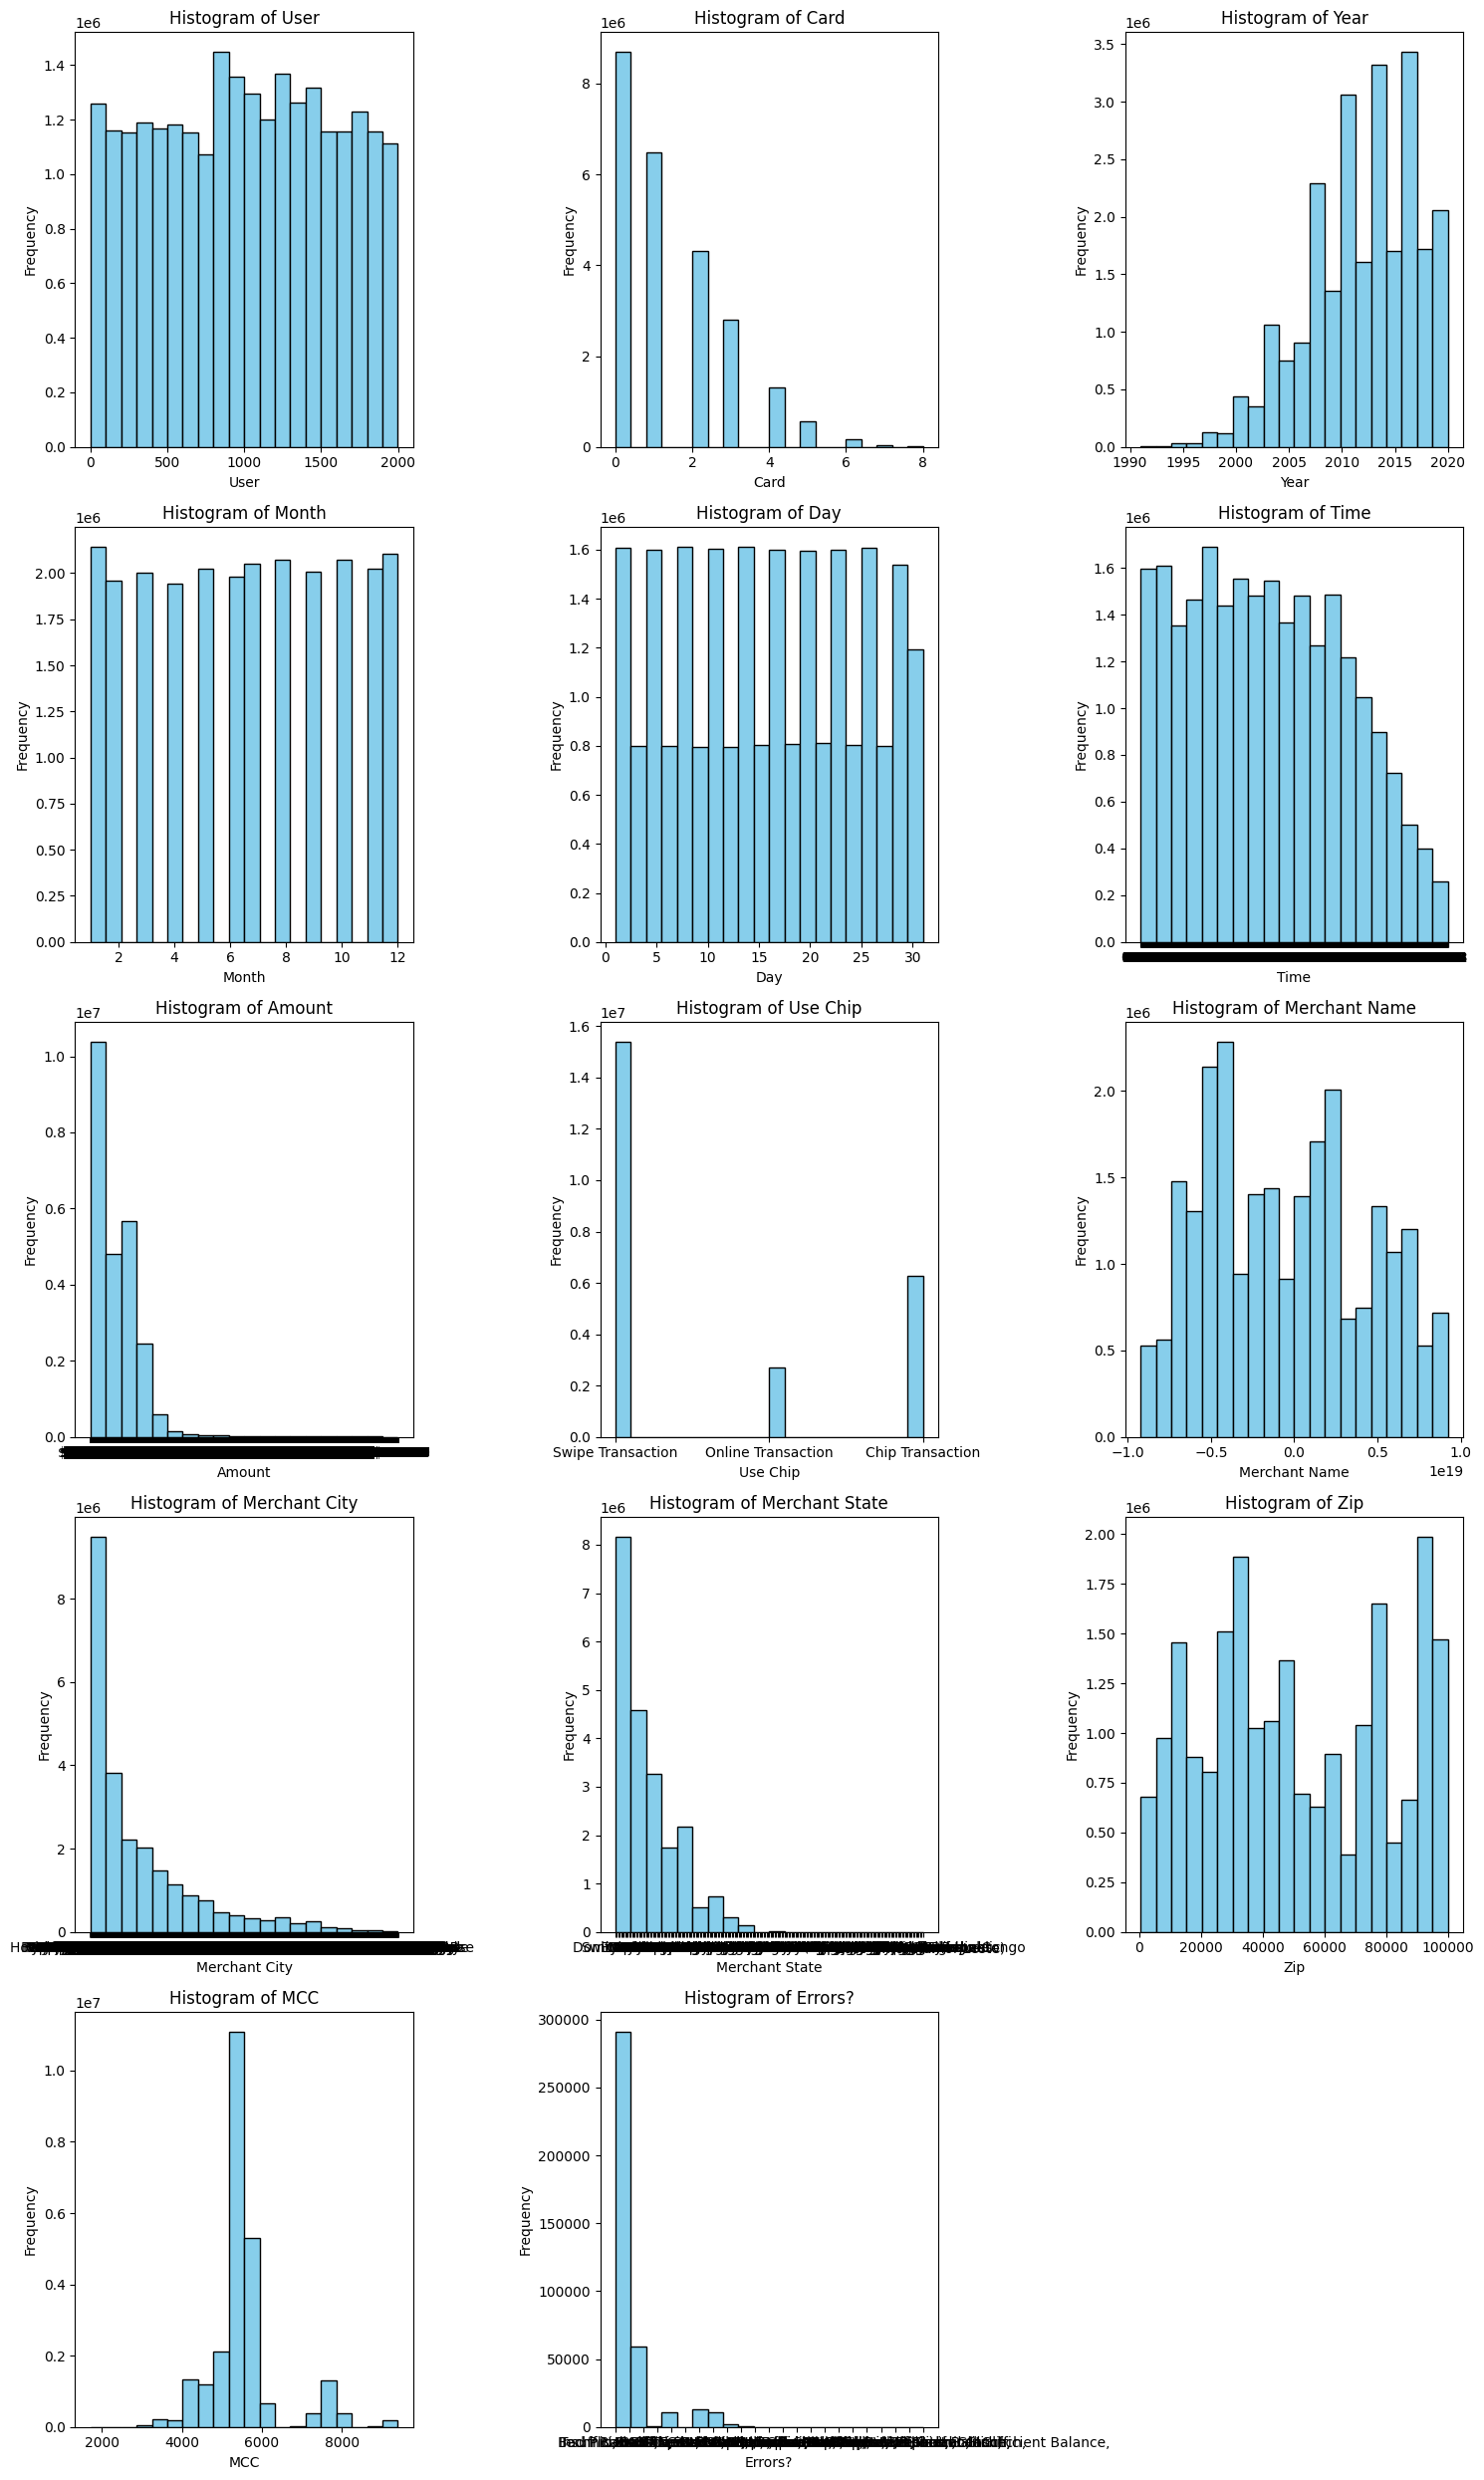

In [4]:
from matplotlib import pyplot as plt

ncols = len(num_cols)
bins = 20

fig, axes = plt.subplots(nrows=(ncols // 3) + (ncols % 3 > 0), ncols=3, figsize=(15, 5 * ((ncols // 3) + (ncols % 3 > 0))))
axes = axes.flatten() if ncols > 1 else [axes]

# Plot each numeric column
for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=bins, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [5]:
df['Is Fraud?'].value_counts()

Is Fraud?
No     24357143
Yes       29757
Name: count, dtype: int64

In [9]:
label_counts = df['Errors?'].value_counts()

In [18]:
filtered_labels = {k: v for k, v in label_counts.items() if v > 500}

In [19]:
filtered_labels

{'Insufficient Balance,': 242783,
 'Bad PIN,': 58918,
 'Technical Glitch,': 48157,
 'Bad Card Number,': 13321,
 'Bad CVV,': 10740,
 'Bad Expiration,': 10716,
 'Bad Zipcode,': 2079,
 'Bad PIN,Insufficient Balance,': 581}

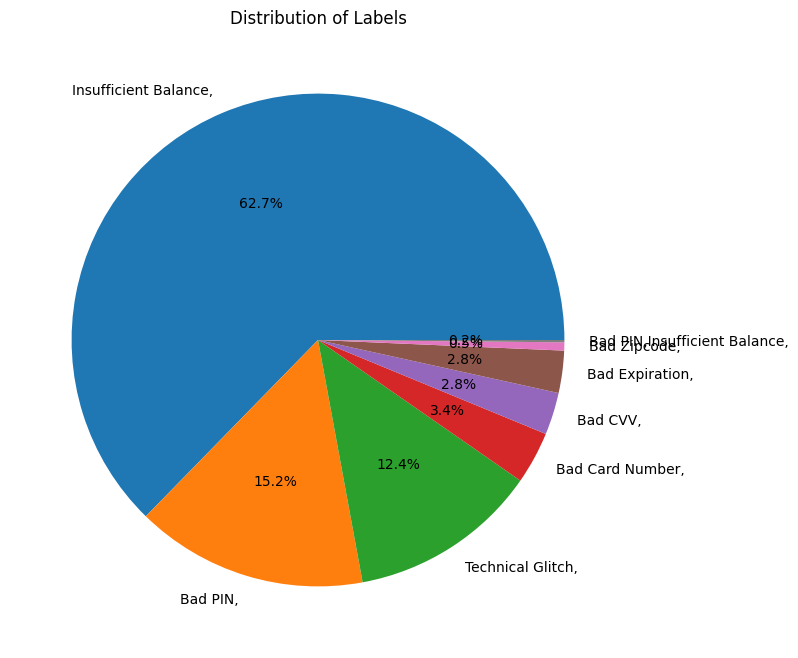

In [20]:
plt.figure(figsize=(8, 8))
plt.pie(
    filtered_labels.values(),
    labels=filtered_labels.keys(),
    autopct='%1.1f%%',
)
plt.title('Distribution of Labels')
plt.show()

In [8]:
categorical_cols = ['Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State']
categorical_stats = {}

for col in categorical_cols:
    categorical_stats[col] = df[col].value_counts()

print("\nCategorical Columns Statistics:")
for col, counts in categorical_stats.items():
    print(f"\nColumn: {col}")
    print(counts)


Categorical Columns Statistics:

Column: Use Chip
Use Chip
Swipe Transaction     15386082
Chip Transaction       6287598
Online Transaction     2713220
Name: count, dtype: int64

Column: Merchant Name
Merchant Name
 1799189980464955940    1130230
-4282466774399734331    1129061
 2027553650310142703    1028485
-2088492411650162548     720615
-1288082279022882052     687779
                         ...   
-8041761960067040601          1
 6535062139561028013          1
-1062300255087527932          1
 2130137907875549406          1
-6468820437317855984          1
Name: count, Length: 100343, dtype: int64

Column: Merchant City
Merchant City
 ONLINE         2720821
Houston          246036
Los Angeles      180496
Miami            178653
Brooklyn         155425
                 ...   
Skellytown            1
Port Haywood          1
Island                1
Bluejacket            1
Geary                 1
Name: count, Length: 13429, dtype: int64

Column: Merchant State
Merchant State
CA       

## Create dataset

In [ ]:
df.columns

## Vocabulary

In [50]:
from collections import OrderedDict
import numpy as np

# Dictionary class that allows attribute-style access
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

class Vocabulary:
    def __init__(self, target_column_name="Is Fraud?"):
        # Special tokens used in the vocabulary
        self.unk_token = "[UNK]"
        self.sep_token = "[SEP]"
        self.pad_token = "[PAD]"
        self.cls_token = "[CLS]"
        self.mask_token = "[MASK]"
        self.bos_token = "[BOS]"
        self.eos_token = "[EOS]"

        self.target_column_name = target_column_name  # Target column for classification
        self.special_field_tag = "SPECIAL"  # Special category for special tokens

        self.special_tokens = [self.unk_token, self.sep_token, self.pad_token,
                               self.cls_token, self.mask_token, self.bos_token, self.eos_token]

        # Mappings between tokens and their corresponding IDs
        self.token2id = OrderedDict()
        self.id2token = OrderedDict()
        self.field_keys = OrderedDict()
        self.token2id[self.special_field_tag] = OrderedDict()

        for token in self.special_tokens:
            global_id = len(self.id2token)
            local_id = len(self.token2id[self.special_field_tag])

            self.token2id[self.special_field_tag][token] = [global_id, local_id]
            self.id2token[global_id] = [token, self.special_field_tag, local_id]

    def set_id(self, token, field_name, return_local=False):
        """
        Assigns a unique global and local ID to a token within a given field.
        If the token already exists, returns its existing ID.
        """
        global_id, local_id = None, None

        if token not in self.token2id[field_name]:
            global_id = len(self.id2token)
            local_id = len(self.token2id[field_name])

            self.token2id[field_name][token] = [global_id, local_id]
            self.id2token[global_id] = [token, field_name, local_id]
        else:
            global_id, local_id = self.token2id[field_name][token]

        return local_id if return_local else global_id

    def get_id(self, token, field_name="", special_token=False, return_local=False):
        """
        Retrieves the global or local ID of a given token within a field.
        Raises an exception if the token is not found.
        """
        if special_token:
            field_name = self.special_field_tag

        if token in self.token2id[field_name]:
            global_id, local_id = self.token2id[field_name][token]
        else:
            raise Exception(f"Token {token} not found in field: {field_name}")

        return local_id if return_local else global_id

    def set_field_keys(self, keys):
        """
        Initializes field keys with empty OrderedDicts.
        """
        for key in keys:
            self.token2id[key] = OrderedDict()
            self.field_keys[key] = None

        self.field_keys[self.special_field_tag] = None

    def get_field_ids(self, field_name, return_local=False):
        """
        Retrieves all IDs for a given field.
        """
        if field_name in self.token2id:
            ids = self.token2id[field_name]
        else:
            raise Exception(f"Field naming {field_name} is incorrect.")

        selected_idx = 1 if return_local else 0
        return [ids[idx][selected_idx] for idx in ids]

    def get_from_global_ids(self, global_ids, what_to_get='local_ids'):
        """
        Converts global IDs to local IDs or token names.
        """
        device = global_ids.device

        def map_global_ids_to_local_ids(gid):
            return self.id2token[gid][2] if gid != -100 else -100

        def map_global_ids_to_tokens(gid):
            return f'{self.id2token[gid][1]}_{self.id2token[gid][0]}' if gid != -100 else '-'

        if what_to_get == 'local_ids':
            return global_ids.cpu().apply_(map_global_ids_to_local_ids).to(device)
        elif what_to_get == 'tokens':
            vectorized_token_map = np.vectorize(map_global_ids_to_tokens)
            new_array_for_tokens = global_ids.detach().clone().cpu().numpy()
            return vectorized_token_map(new_array_for_tokens)
        else:
            raise ValueError("Invalid value for 'what_to_get'")

    def get_field_keys(self, remove_target=True, ignore_special=False):
        """
        Returns a list of field keys, optionally removing the target column and special tokens.
        """
        keys = list(self.field_keys.keys())

        if remove_target and self.target_column_name in keys:
            keys.remove(self.target_column_name)
        if ignore_special:
            keys.remove(self.special_field_tag)
        return keys

    def get_special_tokens(self):
        """
        Returns a dictionary mapping special token names to their corresponding values.
        """
        special_tokens_map = {}
        keys = ["unk_token", "sep_token", "pad_token", "cls_token", "mask_token", "bos_token", "eos_token"]
        for key, token in zip(keys, self.special_tokens):
            token = "%s_%s" % (self.special_field_tag, token)
            special_tokens_map[key] = token

        return AttrDict(special_tokens_map)

    def __len__(self):
        """
        Returns the total number of tokens in the vocabulary.
        """
        return len(self.id2token)

    def __str__(self):
        """
        Returns a string representation of the vocabulary.
        """
        return f'vocab: [{len(self)} tokens]  [field_keys={self.field_keys}]'


In [51]:
import os
from os import path
import pandas as pd
import numpy as np
import math
import tqdm
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import torch
from torch.utils.data.dataset import Dataset

# Utility to divide a list into chunks of size `n`
def divide_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

# Custom PyTorch Dataset for handling transaction data
class TransactionDataset(Dataset):
    def __init__(self,
                 user_ids=None,
                 seq_len=5,
                 num_bins=15,
                 root="./",
                 fname="card_transaction.v1.csv",
                 vocab_dir="checkpoints",
                 nrows=None,
                 flatten=True,
                 stride=3,
                 adap_thres=10 ** 8,
                 return_labels=False,
                 skip_user=False,
                 task_type="masking_learning"):
        # Initialize dataset parameters and configurations
        self.root = root
        self.fname = fname
        self.nrows = nrows
        self.user_ids = user_ids
        self.return_labels = return_labels
        self.skip_user = skip_user
        self.trans_stride = stride
        self.flatten = flatten
        self.vocab = Vocabulary(adap_thres)  # Vocabulary for encoding transaction fields
        self.seq_len = seq_len
        self.encoder_fit = {}  # To store encoders for different fields
        self.trans_table = None  # Transaction data
        self.data = []  # Encoded transaction data
        self.labels = []  # Transaction labels
        self.window_label = []  # Fraud labels for sliding windows
        self.ncols = None
        self.num_bins = num_bins
        self.task_type = task_type

        # Load and preprocess the data
        self.encode_data()
        # Initialize vocabulary with transaction field keys
        self.init_vocab()
        # Prepare the samples for training/testing
        self.prepare_samples()

    def __getitem__(self, index):
        # Return a single sample, optionally flattened
        return_data = torch.tensor(self.data[index], dtype=torch.long)

        if self.task_type == "classification":
            return{
                "input_ids": torch.tensor(self.data[index], dtype=torch.long),
                "label": self.window_label[index]
            }

        if self.return_labels:
            return_data = (return_data, torch.tensor(self.labels[index], dtype=torch.long))


        return return_data

    def __len__(self):
        return len(self.data)

    @staticmethod
    def label_fit_transform(column, enc_type="label"):
        # Fit and transform a column using LabelEncoder or MinMaxScaler
        if enc_type == "label":
            mfit = LabelEncoder()
        else:
            mfit = MinMaxScaler()
        mfit.fit(column)
        return mfit, mfit.transform(column)

    @staticmethod
    def timeEncoder(X):
        # Convert time columns into a single timestamp
        X_hm = X['Time'].str.split(':', expand=True)
        d = pd.to_datetime(dict(year=X['Year'], month=X['Month'], day=X['Day'], hour=X_hm[0], minute=X_hm[1])).astype(int)
        return pd.DataFrame(d)

    @staticmethod
    def amountEncoder(X):
        # Encode amount by applying logarithm transformation
        amt = X.apply(lambda x: x[1:]).astype(float).apply(lambda amt: max(1, amt)).apply(math.log)
        return pd.DataFrame(amt)

    @staticmethod
    def fraudEncoder(X):
        # Encode fraud column as binary (0/1)
        fraud = (X == 'Yes').astype(int)
        return pd.DataFrame(fraud)

    @staticmethod
    def nanNone(X):
        # Replace NaN values with 'None'
        return X.where(pd.notnull(X), 'None')

    @staticmethod
    def nanZero(X):
        # Replace NaN values with 0
        return X.where(pd.notnull(X), 0)

    def _quantization_binning(self, data):
        # Create bins for quantization of continuous values
        qtls = np.arange(0.0, 1.0 + 1 / self.num_bins, 1 / self.num_bins)
        bin_edges = np.quantile(data, qtls, axis=0)
        bin_widths = np.diff(bin_edges, axis=0)
        bin_centers = bin_edges[:-1] + bin_widths / 2
        return bin_edges, bin_centers, bin_widths

    def _quantize(self, inputs, bin_edges):
        # Quantize continuous data into discrete bins
        quant_inputs = np.zeros(inputs.shape[0])
        for i, x in enumerate(inputs):
            quant_inputs[i] = np.digitize(x, bin_edges)
        quant_inputs = quant_inputs.clip(1, self.num_bins) - 1
        return quant_inputs

    def user_level_data(self):
        # Aggregate data at the user level
        trans_data, trans_labels = [], []
        unique_users = self.trans_table["User"].unique()
        columns_names = list(self.trans_table.columns)

        for user in tqdm.tqdm(unique_users):
            user_data = self.trans_table.loc[self.trans_table["User"] == user]
            user_trans, user_labels = [], []
            for idx, row in user_data.iterrows():
                row = list(row)
                skip_idx = 1 if self.skip_user else 0
                user_trans.extend(row[skip_idx:-1])
                user_labels.append(row[-1])

            trans_data.append(user_trans)
            trans_labels.append(user_labels)

        if self.skip_user:
            columns_names.remove("User")

        return trans_data, trans_labels, columns_names

    def format_trans(self, trans_lst, column_names):
        # Format transactions into vocabulary IDs
        trans_lst = list(divide_chunks(trans_lst, len(self.vocab.field_keys) - 2))
        user_vocab_ids = []
        sep_id = self.vocab.get_id(self.vocab.sep_token, special_token=True)

        for trans in trans_lst:
            vocab_ids = []
            for jdx, field in enumerate(trans):
                vocab_id = self.vocab.get_id(field, column_names[jdx])
                vocab_ids.append(vocab_id)
            vocab_ids.append(sep_id)
            user_vocab_ids.append(vocab_ids)

        return user_vocab_ids

    def prepare_samples(self):
        # Prepare input samples for training/testing
        trans_data, trans_labels, columns_names = self.user_level_data()

        for user_idx in tqdm.tqdm(range(len(trans_data))):
            user_row = trans_data[user_idx]
            user_row_ids = self.format_trans(user_row, columns_names)
            user_labels = trans_labels[user_idx]

            for jdx in range(0, len(user_row_ids) - self.seq_len + 1, self.trans_stride):
                ids = user_row_ids[jdx:(jdx + self.seq_len)]
                ids = [idx for ids_lst in ids for idx in ids_lst]
                self.data.append(ids)

            for jdx in range(0, len(user_labels) - self.seq_len + 1, self.trans_stride):
                ids = user_labels[jdx:(jdx + self.seq_len)]
                self.labels.append(ids)
                fraud = 0
                if len(np.nonzero(ids)[0]) > 0:
                    fraud = 1
                self.window_label.append(fraud)

        assert len(self.data) == len(self.labels)
        self.ncols = len(self.vocab.field_keys) - 2 + 1

    def get_csv(self, fname):
        # Load transaction data from a CSV file
        data = pd.read_csv(fname, nrows=self.nrows)
        if self.user_ids:
            self.user_ids = map(int, self.user_ids)
            data = data[data['User'].isin(self.user_ids)]

        self.nrows = data.shape[0]
        return data

    def init_vocab(self):
        # Initialize vocabulary with transaction data
        column_names = list(self.trans_table.columns)
        if self.skip_user:
            column_names.remove("User")

        self.vocab.set_field_keys(column_names)

        for column in column_names:
            unique_values = self.trans_table[column].value_counts(sort=True).to_dict()
            for val in unique_values:
                self.vocab.set_id(val, column)

        for column in self.vocab.field_keys:
            vocab_size = len(self.vocab.token2id[column])
            if vocab_size > self.vocab.adap_thres:
                self.vocab.adap_sm_cols.add(column)

    def encode_data(self):
        # Preprocess and encode transaction data
        dirname = path.join(self.root, "preprocessed")
        data_file = path.join(self.root, self.fname)
        data = self.get_csv(data_file)

        # Handle missing values and encode fields
        data['Errors?'] = self.nanNone(data['Errors?'])
        data['Is Fraud?'] = self.fraudEncoder(data['Is Fraud?'])
        data['Zip'] = self.nanZero(data['Zip'])
        data['Merchant State'] = self.nanNone(data['Merchant State'])
        data['Use Chip'] = self.nanNone(data['Use Chip'])
        data['Amount'] = self.amountEncoder(data['Amount'])

        sub_columns = ['Errors?', 'MCC', 'Zip', 'Merchant State', 'Merchant City', 'Merchant Name', 'Use Chip']

        for col_name in tqdm.tqdm(sub_columns):
            col_data = data[col_name]
            col_fit, col_data = self.label_fit_transform(col_data)
            self.encoder_fit[col_name] = col_fit
            data[col_name] = col_data

        timestamp = self.timeEncoder(data[['Year', 'Month', 'Day', 'Time']])
        timestamp_fit, timestamp = self.label_fit_transform(timestamp, enc_type="time")
        self.encoder_fit['Timestamp'] = timestamp_fit
        data['Timestamp'] = timestamp

        coldata = np.array(data['Timestamp'])
        bin_edges, bin_centers, bin_widths = self._quantization_binning(coldata)
        data['Timestamp'] = self._quantize(coldata, bin_edges)
        self.encoder_fit["Timestamp-Quant"] = [bin_edges, bin_centers, bin_widths]

        coldata = np.array(data['Amount'])
        bin_edges, bin_centers, bin_widths = self._quantization_binning(coldata)
        data['Amount'] = self._quantize(coldata, bin_edges)
        self.encoder_fit["Amount-Quant"] = [bin_edges, bin_centers, bin_widths]

        columns_to_select = ['User',
                             'Card',
                             'Timestamp',
                             'Amount',
                             'Use Chip',
                             'Merchant Name',
                             'Merchant City',
                             'Merchant State',
                             'Zip',
                             'MCC',
                             'Errors?',
                             'Is Fraud?']

        self.trans_table = data[columns_to_select]

In [52]:
import random

def random_split_dataset(dataset, lengths, random_seed=22102003):
    random.seed(random_seed)  # python
    np.random.seed(random_seed)  # numpy
    torch.manual_seed(random_seed)  # torch
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)  # torch.cuda

    train_dataset, eval_dataset, test_dataset = torch.utils.data.dataset.random_split(dataset, lengths)
    return train_dataset, eval_dataset, test_dataset


In [53]:
dataset = TransactionDataset(nrows=500_000)
vocab = dataset.vocab
custom_special_tokens = vocab.get_special_tokens()
trainN = int(0.7 * len(dataset))
valtestN = len(dataset) - trainN
valN = int(valtestN * 0.4)
testN = valtestN - valN
lengths = [trainN, valN, testN]
train_dataset, eval_dataset, test_dataset = random_split_dataset(dataset, lengths)

100%|██████████| 40/40 [00:05<00:00,  6.69it/s]


# **Model**

In [54]:
from transformers import BertConfig


class TabFormerBertConfig(BertConfig):
    def __init__(
        self,
        flatten=True,
        ncols=12,
        vocab_size=30522,
        field_hidden_size=64,
        hidden_size=768,
        num_attention_heads=12,
        pad_token_id=0,
        **kwargs
    ):
        super().__init__(pad_token_id=pad_token_id, **kwargs)

        self.ncols = ncols
        self.field_hidden_size = field_hidden_size
        self.hidden_size = hidden_size
        self.flatten = flatten
        self.vocab_size = vocab_size
        self.num_attention_heads=num_attention_heads

In [55]:


from transformers.modeling_utils import PreTrainedModel
from transformers import (
    BertTokenizer,
    BertForMaskedLM,
)


class ddict(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

class TabFormerBertLM:
    def __init__(self, special_tokens, vocab, field_ce=False, flatten=True, ncols=None, field_hidden_size=768):
        self.ncols = ncols
        self.vocab = vocab
        vocab_file = "vocab_big_data"
        hidden_size = field_hidden_size

        self.config = TabFormerBertConfig(vocab_size=len(self.vocab),
                                          ncols=self.ncols,
                                          hidden_size=hidden_size,
                                          field_hidden_size=field_hidden_size,
                                          flatten=flatten,
                                          num_attention_heads=self.ncols)

        self.tokenizer = BertTokenizer(vocab_file,
                                       do_lower_case=False,
                                       **special_tokens)
        self.model = self.get_model(field_ce, flatten)

    def get_model(self, field_ce, flatten):
        return BertForMaskedLM(self.config)

In [56]:

with open("vocab_big_data", "w") as fout:
    for idx in vocab.id2token:
        token, field, _ = vocab.id2token[idx]
        token = "%s_%s" % (field, token)
        fout.write("%s\n" % token)

In [57]:
tab_net = TabFormerBertLM(
    custom_special_tokens,
    vocab=vocab,
    ncols=dataset.ncols,
)

Generate config GenerationConfig {
  "pad_token_id": 0
}



# **Collator**

In [58]:
from typing import Dict, List, Tuple, Union
import torch
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments


class TransDataCollatorForLanguageModeling(DataCollatorForLanguageModeling):

    def __call__(
            self, examples: List[Union[List[int], torch.Tensor, Dict[str, torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        batch = self._tensorize_batch(examples)
        # batch = self._collate_batch(examples, self.tokenizer)
        sz = batch.shape
        batch = batch.view(sz[0], -1)
        inputs, labels = self.mask_tokens(batch)
        return {"input_ids": inputs.view(sz), "labels": labels.view(sz)}

    def _tensorize_batch(
         self, examples: List[Union[List[int], torch.Tensor, Dict[str, torch.Tensor]]]
     ) -> torch.Tensor:
         if isinstance(examples[0], (list, tuple)):
             examples = [torch.Tensor(e) for e in examples]
         length_of_first = examples[0].size(0)
         are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
         if are_tensors_same_length:
             return torch.stack(examples, dim=0)
         else:
             return pad_sequence(examples, batch_first=True, padding_value=self.tokenizer.pad_token_id)

    def mask_tokens(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Prepare masked tokens inputs/labels for masked language modeling.
        """
        labels = inputs.clone()
        # We sample a few tokens in each sequence for masked-LM training
        probability_matrix = torch.full(labels.shape, self.mlm_probability)
        special_tokens_mask = [
            self.tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
        ]
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
        if self.tokenizer._pad_token is not None:
            padding_mask = labels.eq(self.tokenizer.pad_token_id)
            probability_matrix.masked_fill_(padding_mask, value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()
        labels[~masked_indices] = -100  # We only compute loss on masked tokens

        # we replace masked input tokens with tokenizer.mask_token ([MASK])
        indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
        inputs[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

        # we replace masked input tokens with random word
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.tokenizer), labels.shape, dtype=torch.long)
        inputs[indices_random] = random_words[indices_random]

        return inputs, labels

In [59]:
data_collator = TransDataCollatorForLanguageModeling(
    tokenizer=tab_net.tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [14]:
!wandb login 5ff0f835268a508460f994cd971c937a4a6b930e

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [15]:
import wandb

# Initialize W&B
wandb.init(
    project="transaction-fraud-detection",
    name="bert-tabular-model-19",
    config={
        "epochs": 100,
        "batch_size": 32,
        "learning_rate": 5e-5,
    }
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: stepashkina-vita. Use `wandb login --relogin` to force relogin


In [33]:
from transformers import logging
logging.set_verbosity_info()

In [34]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class CustomProgressBar(TrainerCallback):
    def __init__(self):
        self.pbar = None

    def on_train_begin(self, args, state, control, **kwargs):
        self.pbar = tqdm(total=state.max_steps, desc="Training")

    def on_step_end(self, args, state, control, **kwargs):
        self.pbar.update(1)

    def on_train_end(self, args, state, control, **kwargs):
        self.pbar.close()

In [45]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/",
    num_train_epochs=6,
    logging_dir="/kaggle/working/",
    per_device_train_batch_size=128,
    save_steps=3_500,
    logging_steps=1000,  # Log every 10 steps
    prediction_loss_only=True,
    overwrite_output_dir=True,
    disable_tqdm=False,  # Enable progress bar
    report_to="wandb",
)


PyTorch: setting up devices


In [ ]:
trainer = Trainer(
    model=tab_net.model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[CustomProgressBar()],
)


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 116,638
  Num Epochs = 6
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 5,472
  Number of trainable parameters = 98,177,700
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"

Training:   0%|          | 1/5472 [00:00<1:08:02,  1.34it/s]

Step,Training Loss
1000,0.546000
2000,0.422300



Training:  29%|██▉       | 1614/5472 [20:02<47:52,  1.34it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.

Training:  38%|███▊      | 2079/5472 [25:48<42:01,  1.35it/s]

In [ ]:
# import shutil
# import os
# for i in range(2600, 4401, 200):
#     shutil.rmtree(f"checkpoint-{i}")




In [ ]:
tab_net.model.save_pretrained("/kaggle/working/tab_net")
tab_net.tokenizer.save_pretrained("/kaggle/working/tab_net")


Configuration saved in /kaggle/working/tab_net/config.json
Configuration saved in /kaggle/working/tab_net/generation_config.json
Model weights saved in /kaggle/working/tab_net/model.safetensors
tokenizer config file saved in /kaggle/working/tab_net/tokenizer_config.json
Special tokens file saved in /kaggle/working/tab_net/special_tokens_map.json


('/kaggle/working/tab_net/tokenizer_config.json',
 '/kaggle/working/tab_net/special_tokens_map.json',
 '/kaggle/working/tab_net/vocab.txt',
 '/kaggle/working/tab_net/added_tokens.json')

# **Classification part**

In [60]:
from typing import Dict, List, Union
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import DataCollatorWithPadding

class ClassificationDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(
        self, examples: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]
        labels = [example["label"] for example in examples]
        batch = self._tensorize_batch(input_ids)
        labels = torch.tensor(labels, dtype=torch.long)

        return {"input_ids": batch, "labels": labels}

    def _tensorize_batch(
        self, examples: List[torch.Tensor]
    ) -> torch.Tensor:
        length_of_first = examples[0].size(0)
        are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
        if are_tensors_same_length:
            return torch.stack(examples, dim=0)
        else:
            return pad_sequence(examples, batch_first=True, padding_value=self.tokenizer.pad_token_id)


In [61]:
# Metric computation
def compute_metrics(pred):
    logits, labels = pred.predictions, pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    
    if len(predictions.shape) > 1:
        predictions = predictions.flatten()
    if len(labels.shape) > 1:
        labels = labels.flatten()

    print(f"Logits shape: {logits.shape}")
    print(f"Labels shape: {labels.shape}")

    roc_auc = roc_auc_score(labels, logits[:, 1]) if logits.shape[1] > 1 else 0.0

    print(f"ROC AUC: {roc_auc}")
    return {
        "roc_auc": roc_auc,
    }

In [62]:
dataset = TransactionDataset(nrows=500_000, task_type = "classification")
vocab = dataset.vocab
custom_special_tokens = vocab.get_special_tokens()
trainN = int(0.7 * len(dataset))
valtestN = len(dataset) - trainN
valN = int(valtestN * 0.4)
testN = valtestN - valN
lengths = [trainN, valN, testN]
train_dataset, eval_dataset, test_dataset = random_split_dataset(dataset, lengths)

100%|██████████| 40/40 [00:06<00:00,  6.62it/s]


In [49]:
from tqdm.notebook import tqdm

# **EXP №1:** bert as an extractor + simple head

In [ ]:
loaded_tab_net = BertForMaskedLM.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")
loaded_tokenizer = BertTokenizer.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")

In [ ]:
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding


class FraudDetectionModel(nn.Module):
    def __init__(self, bert_model, hidden_size, num_classes=2):
        super(FraudDetectionModel, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes)
        )

        # freezed BERT
        for param in self.bert.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Obtaining hidden states from BERT
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]
        pooled_output = last_hidden_state[:, 0, :]  # Obtaining [CLS] tokens
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return loss, logits
        return logits



data_collator = ClassificationDataCollator(tokenizer=loaded_tokenizer)

training_args = TrainingArguments(
    output_dir="fraud_detection_results",
    evaluation_strategy="no",
    learning_rate=3e-6,
    per_device_train_batch_size=128,
    num_train_epochs=20,
    weight_decay=0.1,
    logging_dir="/kaggle/working/",
    save_total_limit=2,
    save_steps=3_500,
    logging_steps=500,
    overwrite_output_dir=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_roc_auc",
    save_strategy = 'no',
    disable_tqdm=False,  # Enable progress bar
    report_to="wandb",
)

# Model setup
num_classes = 2  # Fraud (1) or Not Fraud (0)
hidden_size = loaded_tab_net.config.hidden_size
fraud_model = FraudDetectionModel(loaded_tab_net, hidden_size, num_classes)


# Initialize trainer
trainer = Trainer(
    model=fraud_model,
    args=training_args,
    train_dataset=train_dataset, 
    eval_dataset=eval_dataset,
    tokenizer=loaded_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
***** Running training *****
  Num examples = 116,638
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 18,240
  Number of trainable parameters = 903,974
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases.
<ipython-input-12-772cbad777dd>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(example["input_ids"]

Step,Training Loss
500,0.245800
1000,0.036700
1500,0.019400
2000,0.015700
2500,0.014800
3000,0.015400
3500,0.013500
4000,0.013700
4500,0.014300
5000,0.013800




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=18240, training_loss=0.021015113945070066, metrics={'train_runtime': 3973.0516, 'train_samples_per_second': 587.146, 'train_steps_per_second': 4.591, 'total_flos': 0.0, 'train_loss': 0.021015113945070066, 'epoch': 20.0})

In [ ]:
test_results = trainer.evaluate(test_dataset)
print(f"Test ROC AUC: {test_results['eval_roc_auc']}")



***** Running Evaluation *****
  Num examples = 29993
  Batch size = 8
<ipython-input-12-772cbad777dd>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]


Logits shape: (29993, 2)
Labels shape: (29993,)
ROC AUC: 0.6940571275798358
Test ROC AUC: 0.6940571275798358


# **EXP №2:** bert + downstream-tuning simple head

In [ ]:
loaded_tab_net = BertForMaskedLM.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")
loaded_tokenizer = BertTokenizer.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")

loading configuration file /kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "field_hidden_size": 768,
  "flatten": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "ncols": 12,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 15780
}

loading weights file /kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs/model.safetensors
Generate config GenerationConfig {
  "pad_token_id": 0
}

All model checkpoint weights were used when initializing BertForMask

In [ ]:
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding


class FraudDetectionModel(nn.Module):
    def __init__(self, bert_model, hidden_size, num_classes=2):
        super(FraudDetectionModel, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes)
        )

        # freezed BERT
        for param in self.bert.bert.parameters():
            param.requires_grad = False

        for param in self.bert.bert.encoder.layer[-1].parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Obtaining hidden states from BERT
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]
        pooled_output = last_hidden_state[:, 0, :]  # Using [CLS] token
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return loss, logits
        return logits



data_collator = ClassificationDataCollator(tokenizer=loaded_tokenizer)

# Training and evaluation arguments
training_args = TrainingArguments(
    output_dir="fraud_detection_results",
    evaluation_strategy="no",
    learning_rate=3e-6,
    per_device_train_batch_size=128,
    num_train_epochs=20,
    weight_decay=0.1,
    logging_dir="/kaggle/working/",
    save_total_limit=2,
    save_steps=3_500,
    logging_steps=500,
    overwrite_output_dir=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_roc_auc",
    save_strategy = 'no',
    disable_tqdm=False,  # Enable progress bar
    report_to="wandb",
)

# Model setup
num_classes = 2  # Fraud (1) or Not Fraud (0)
hidden_size = loaded_tab_net.config.hidden_size
fraud_model = FraudDetectionModel(loaded_tab_net, hidden_size, num_classes)


trainer = Trainer(
    model=fraud_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=loaded_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
***** Running training *****
  Num examples = 116,638
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 18,240
  Number of trainable parameters = 7,991,846
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases.
<ipython-input-12-772cbad777dd>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(example["input_ids

Step,Training Loss
500,0.106700
1000,0.014900
1500,0.013400
2000,0.013300
2500,0.013800
3000,0.014500
3500,0.012800
4000,0.012900
4500,0.013300
5000,0.012600


In [ ]:
test_results = trainer.evaluate(test_dataset)
print(f"Test ROC AUC: {test_results['eval_roc_auc']}")



***** Running Evaluation *****
  Num examples = 29993
  Batch size = 8
<ipython-input-12-772cbad777dd>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]


Logits shape: (29993, 2)
Labels shape: (29993,)
ROC AUC: 0.8993411661359394
Test ROC AUC: 0.8993411661359394


In [ ]:
training_args = TrainingArguments(
    output_dir="fraud_detection_results",
    evaluation_strategy="no",
    learning_rate=1e-6,
    per_device_train_batch_size=128,
    num_train_epochs=10,
    weight_decay=0.1,
    logging_dir="/kaggle/working/",
    save_total_limit=2,
    save_steps=3_500,
    logging_steps=500,
    overwrite_output_dir=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_roc_auc",
    save_strategy = 'no',
    disable_tqdm=False,  # Enable progress bar
    report_to="wandb",
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices


In [ ]:
trainer = Trainer(
    model=fraud_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=loaded_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

***** Running training *****
  Num examples = 116,638
  Num Epochs = 10
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 9,120
  Number of trainable parameters = 7,991,846
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases.
<ipython-input-12-772cbad777dd>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]


Step,Training Loss
500,0.009200
1000,0.009300
1500,0.008100
2000,0.008200
2500,0.009300
3000,0.009000
3500,0.007200
4000,0.008600


In [ ]:
test_results = trainer.evaluate(test_dataset)  # Replace with your test dataset
print(f"Test ROC AUC: {test_results['eval_roc_auc']}")


***** Running Evaluation *****
  Num examples = 29993
  Batch size = 8
<ipython-input-12-772cbad777dd>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]


Logits shape: (29993, 2)
Labels shape: (29993,)
ROC AUC: 0.9127971316856122
Test ROC AUC: 0.9127971316856122


# **EXP №3:** bert + GRU head


In [ ]:
# loaded_tab_net = BertForMaskedLM.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")
# loaded_tokenizer = BertTokenizer.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")
loaded_tab_net = BertForMaskedLM.from_pretrained("/content/wandb/bert")
loaded_tokenizer = BertTokenizer.from_pretrained("/content/wandb/bert")

loading configuration file /content/wandb/bert/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "field_hidden_size": 768,
  "flatten": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "ncols": 12,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 15780
}

loading weights file /content/wandb/bert/model.safetensors
Generate config GenerationConfig {
  "pad_token_id": 0
}

All model checkpoint weights were used when initializing BertForMaskedLM.

All the weights of BertForMaskedLM were initialized from the model checkp

In [71]:
from sklearn.metrics import roc_auc_score, f1_score

In [ ]:
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score
from transformers import DataCollatorWithPadding

class FraudDetectionModelWithGRU(nn.Module):
    def __init__(self, bert_model, hidden_size, gru_hidden_size, num_classes=2):
        super(FraudDetectionModelWithGRU, self).__init__()
        self.bert = bert_model

        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=gru_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Linear(gru_hidden_size * 2, num_classes)

        for param in self.bert.bert.parameters():
            param.requires_grad = False

        for param in self.bert.bert.encoder.layer[-1].parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]  # last layer (batch_size, seq_len, hidden_size)

        gru_output, _ = self.gru(last_hidden_state)  # gru_output: (batch_size, seq_len, gru_hidden_size * 2)

        # Using [CLS] token
        cls_representation = gru_output[:, 0, :]  # (batch_size, gru_hidden_size * 2)

        # classifier
        logits = self.classifier(cls_representation)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return loss, logits
        return logits

# Data collator
data_collator = ClassificationDataCollator(tokenizer=loaded_tokenizer)

# Training and evaluation arguments
training_args = TrainingArguments(
    output_dir="fraud_detection_results",
    evaluation_strategy="no",
    learning_rate=7e-6,
    per_device_train_batch_size=128,
    num_train_epochs=20,
    weight_decay=0.1,
    # logging_dir="/kaggle/working/",
    logging_dir="/content/",
    save_total_limit=2,
    save_steps=3_500,
    logging_steps=1000,
    overwrite_output_dir=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_roc_auc",
    save_strategy = 'no',
    disable_tqdm=False,
    report_to="wandb",
)

# Model setup
num_classes = 2  # Fraud (1) or Not Fraud (0)
hidden_size = loaded_tab_net.config.hidden_size
gru_hidden_size = 618
fraud_model = FraudDetectionModelWithGRU(loaded_tab_net, hidden_size, gru_hidden_size, num_classes)

# Trainer setup
trainer = Trainer(
    model=fraud_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=loaded_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
<ipython-input-34-cc39e4a6baf2>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
***** Running training *****
  Num examples = 116,638
  Num Epochs = 20
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 18,240
  Number of trainable parameters = 12,844,958
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different

Step,Training Loss
1000,0.026800
2000,0.012300
3000,0.011000
4000,0.008200
5000,0.007700
6000,0.007000
7000,0.006100
8000,0.005700
9000,0.005600
10000,0.005100


Step,Training Loss
1000,0.026800
2000,0.012300
3000,0.011000
4000,0.008200
5000,0.007700
6000,0.007000
7000,0.006100
8000,0.005700
9000,0.005600
10000,0.005100


KeyboardInterrupt: 

In [ ]:
test_results = trainer.evaluate(test_dataset)
print(f"Test ROC AUC: {test_results['eval_roc_auc']}")


***** Running Evaluation *****
  Num examples = 29993
  Batch size = 8
<ipython-input-31-772cbad777dd>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]


Logits shape: (29993, 2)
Labels shape: (29993,)
ROC AUC: 0.9715555640429483
Test ROC AUC: 0.9715555640429483


# **EXP №4 :** bert + LSTM + attention head


In [63]:
loaded_tab_net = BertForMaskedLM.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")
loaded_tokenizer = BertTokenizer.from_pretrained("/kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs")

loading configuration file /kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "field_hidden_size": 768,
  "flatten": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "ncols": 12,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.47.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 15780
}

loading weights file /kaggle/input/bert_6_epochs/pytorch/default/1/bert_6_epochs/model.safetensors
Generate config GenerationConfig {
  "pad_token_id": 0
}

All model checkpoint weights were used when initializing BertForMask

In [66]:
from typing import Dict, List, Union
import torch
from torch.nn.utils.rnn import pad_sequence

class ClassificationDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(
        self, examples: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # Format input_ids to tesors
        input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]
        labels = torch.tensor([example["label"] for example in examples], dtype=torch.long)

        batch = self._tensorize_batch(input_ids)

        return {"input_ids": batch, "labels": labels}

    def _tensorize_batch(self, examples: List[torch.Tensor]) -> torch.Tensor:
        if not isinstance(examples[0], torch.Tensor):
            raise ValueError(f"Expected torch.Tensor but got {type(examples[0])}")

        length_of_first = examples[0].shape[0]
        are_tensors_same_length = all(x.shape[0] == length_of_first for x in examples)

        if are_tensors_same_length:
            return torch.stack(examples, dim=0)
        else:
            return pad_sequence(examples, batch_first=True, padding_value=self.tokenizer.pad_token_id)


In [67]:
import torch
import torch.nn as nn


class FraudDetectionModelWithLSTMAttention(nn.Module):
    def __init__(self, bert_model, hidden_size, lstm_hidden_size, num_classes=2):
        super(FraudDetectionModelWithLSTMAttention, self).__init__()
        self.bert = bert_model

        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.attention = nn.Linear(lstm_hidden_size * 2, 1)
        self.classifier = nn.Linear(lstm_hidden_size * 2, num_classes)

        for param in self.bert.bert.parameters():
            param.requires_grad = False

        for param in self.bert.bert.encoder.layer[-1].parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]  # las layer (batch_size, seq_len, hidden_size)

        lstm_output, _ = self.lstm(last_hidden_state)  # lstm_output: (batch_size, seq_len, lstm_hidden_size * 2)

        # Attention
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)  # (batch_size, seq_len, 1)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)  # (batch_size, lstm_hidden_size * 2)

        # Classifier
        logits = self.classifier(context_vector)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return loss, logits
        return logits


In [69]:
training_args = TrainingArguments(
    output_dir="fraud_detection_results",
    evaluation_strategy="no",
    learning_rate=7e-6,
    per_device_train_batch_size=128,
    num_train_epochs=15,
    weight_decay=0.1,
    logging_dir="/content/",
    save_total_limit=2,
    save_steps=3_500,
    logging_steps=500,
    overwrite_output_dir=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_roc_auc",
    save_strategy = 'no',
    disable_tqdm=False,  # Enable progress bar
    report_to="wandb",
)

# Model setup
num_classes = 2  # Fraud (1) or Not Fraud (0)
hidden_size = loaded_tab_net.config.hidden_size
lstm_hidden_size = 618 
fraud_model = FraudDetectionModelWithLSTMAttention(loaded_tab_net, hidden_size, lstm_hidden_size, num_classes)
data_collator = ClassificationDataCollator(tokenizer=loaded_tokenizer)

# Trainer setup
trainer = Trainer(
    model=fraud_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=loaded_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
<ipython-input-69-07ec8ceb0ea3>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
***** Running training *****
  Num examples = 116,638
  Num Epochs = 15
  Instantaneous batch size per device = 128
  Training with DataParallel so batch size has been adjusted to: 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 6,840
  Number of trainable parameters = 14,561,763
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not log the number of model parameters in Weights & Biases due to an Attribute

Step,Training Loss
500,0.050600
1000,0.012400
1500,0.011600
2000,0.008900
2500,0.007700
3000,0.006900
3500,0.005900
4000,0.005300
4500,0.005000
5000,0.004500




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6840, training_loss=0.00980216648146423, metrics={'train_runtime': 5238.3184, 'train_samples_per_second': 333.995, 'train_steps_per_second': 1.306, 'total_flos': 0.0, 'train_loss': 0.00980216648146423, 'epoch': 15.0})

In [72]:
test_results = trainer.evaluate(test_dataset)
print(f"Test ROC AUC: {test_results['eval_roc_auc']}")


***** Running Evaluation *****
  Num examples = 29993
  Batch size = 16
<ipython-input-66-7078e3284676>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(example["input_ids"], dtype=torch.long) for example in examples]


Logits shape: (29993, 2)
Labels shape: (29993,)
ROC AUC: 0.9628957180572995
Test ROC AUC: 0.9628957180572995
